in light of the results of Spectral signatures of axionlike dark matter (https://arxiv.org/pdf/2107.11948.pdf), I would like to see the effects of filtering a spectrum with bin width > 1e6

Take 1:

Make some noise data in frequency domain. Add to it a small signal of shape

$
\lambda(\nu)=\frac{2 c^{2}}{\sqrt{\pi} v_{0} v_{\text {lab }} \nu_{a}} \exp \left(-\frac{\beta^{2} v_{0}^{2}}{4 v_{\text {lab }}^{2}}-\frac{v_{\text {lab }}^{2}}{v_{0}^{2}}\right) \sinh \beta
$

with

$
\beta=\frac{2 c v_{\mathrm{lab}}}{v_{0}^{2}} \sqrt{\frac{2\left(\nu-\nu_{a}\right)}{\nu_{a}}} .
$

This is too complicated for this first pass and looks like a blackbody spectrum so I'll use $\lambda(\nu) = 1/(e^x - 1)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import cupy 

%matplotlib widget

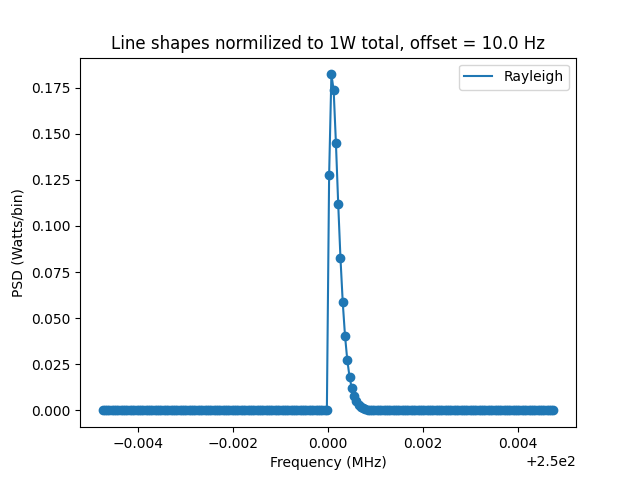

In [11]:
#define line shapes and demo plotting
def gaussian(nu, nu0, deltaNu, offset):
    #unnormilized!
    return np.exp(-(1/2) * (nu - nu0 - offset)**2 / (deltaNu**2))


def lam(nu, nu0, v0=220, vlab=233, offset = 0):
    # Work in MHz, this will explode for large frequency values (ie 100e6 Hz)
    # velocity args in km/s
    # vlab has yearly modulation between about 220 and 255, see fig 3a in Gramolin
    # unnormilized
    c       = 299792 #km/s
    nu0     = nu0 + offset
    beta    = np.zeros_like(nu) # initialise beta with zeros

    mask    = (nu > nu0) # create a mask of values where nu > nu0
    # calculate beta only for values where nu > nu0
    beta[mask] = (2*c*vlab)/(v0**2) * np.sqrt((2*(nu[mask]-nu0))/(nu0))
    beta    = np.minimum(beta, 100)
    a       = (2*c**2)/(np.sqrt(np.pi)*v0*vlab*nu0)
    b       = -((beta**2*v0**2)/(4*vlab**2)) - (vlab**2/v0**2) 

    return a*np.exp(b)*np.sinh(beta)

#nice demo values
#nu0             = 50
#freqs           = np.linspace(nu0-0.00009, nu0 + 0.0002, 36)

# normal values
nu0             = 250
freqs           = np.linspace(0, 400, 2**23)

p0              = 1
offset          = 10e-6

#normilize
gausArr         = gaussian(freqs, nu0, nu0/(1e6*2.355), 0)
gaussianNorm    = p0/np.sum(gausArr)
gaussianPSD     = gaussianNorm * gausArr

lamArr          = lam(freqs, nu0, offset=offset)
rayleighNorm    = p0/np.sum(lamArr)
rayleighPSD     = rayleighNorm * lamArr

nu0Idx          = int(nu0/400 * 2**23)
dPltIdx         = 100

plt.close('all')
plt.figure()
plt.title(f'Line shapes normilized to 1W total, offset = {offset*1e6} Hz')
plt.plot(freqs[nu0Idx-dPltIdx:nu0Idx+dPltIdx], rayleighPSD[nu0Idx-dPltIdx:nu0Idx+dPltIdx], label = 'Rayleigh')
plt.scatter(freqs[nu0Idx-dPltIdx:nu0Idx+dPltIdx], rayleighPSD[nu0Idx-dPltIdx:nu0Idx+dPltIdx])
#plt.plot(freqs[nu0Idx-dPltIdx:nu0Idx+dPltIdx], gaussianPSD[nu0Idx-dPltIdx:nu0Idx+dPltIdx], label = 'Gaussian')
#plt.scatter(freqs[nu0Idx-dPltIdx:nu0Idx+dPltIdx], gaussianPSD[nu0Idx-dPltIdx:nu0Idx+dPltIdx])
plt.xlabel('Frequency (MHz)')
plt.ylabel('PSD (Watts/bin)')
plt.legend()
#plt.plot(freqs, lam(freqs, 50, vlab = 254))




Text(0, 0.5, 'Convolution units?')

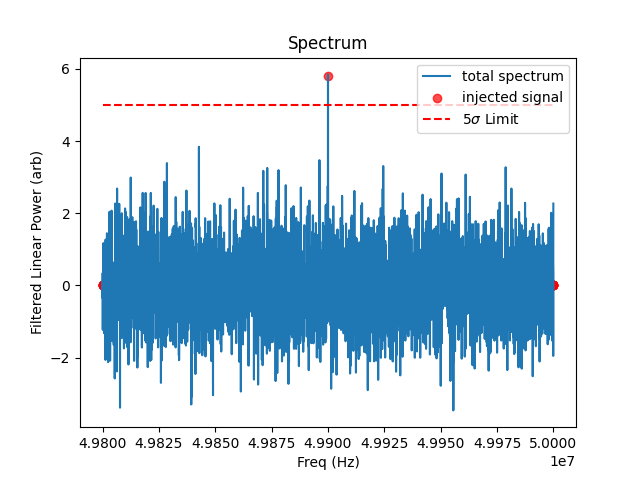

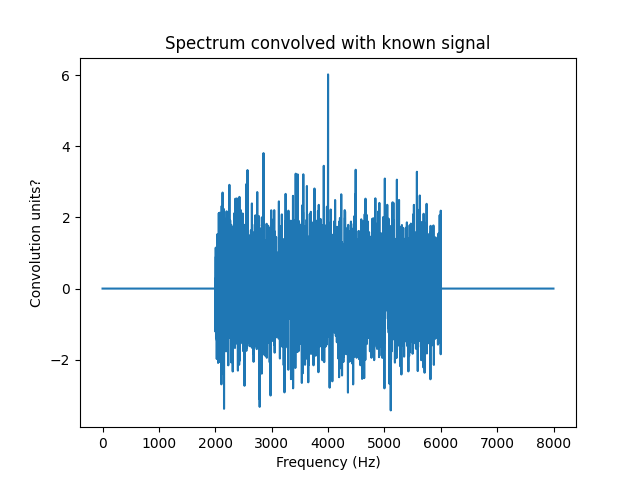

In [3]:
def gaussian(nu, nu0, deltaNu, offset):
    #unnormilized!
    return np.exp(-(1/2) * (nu - nu0 - offset)**2 / (deltaNu**2))

    #comment to ignore normilization
    #return a/(deltaNu * 2 * np.pi) * np.exp(-1/2 * (nu - nu0)**2 / deltaNu)


def simAndConv(
    sigPow,
    sigQ,
    freq
    ):
###generate spectrum in the frequency domain. White noise + other stuff##

    binWidth = 50 #Hz
    freqStart= freq-0.2e6 #MHz
    freqStop = freq #MHz
    freqs = np.arange(freqStart, freqStop, binWidth)
    numBins = len(freqs)

    noiseStd = 1

    interferenceSigSnr = 0
    interferenceQ = sigQ / 100
    interferenceFreq = 100.07e6
    sigFreq = freq - .1e6

    interferenceSigAmp = interferenceSigSnr * noiseStd
    antennaShit         = 0 * np.sin(1/240005*freqs* np.pi) +0
    noiseSpec           = np.random.normal(0, noiseStd, numBins)
    freqJitter          = np.random.uniform(-25, 25)
    qJitter             = np.random.uniform(1/2, 2)
    sigStd = sigFreq/(sigQ*2.355*qJitter)
    template = gaussian(freqs, sigFreq, sigStd, 0)
    signal =  sigPow/template.sum() * gaussian(freqs, sigFreq, sigStd, freqJitter)
    spur = np.zeros(numBins)
    spur[int(numBins*0.35)] = 0
    #wide gaussian simulating interfering signal with wrong Q
    interferenceSig = 0 #gaussian(freqs, interferenceFreq, sigFreq/interferenceQ, interferenceSigAmp)
    spec = noiseSpec + signal + interferenceSig + spur + antennaShit



    #convolution = np.convolve(spec, gaussian(freqs, sigFreq, sigFreq/sigQ, 1), mode = 'full')
    convolution = np.convolve(spec, template, mode = 'full')
    #throw out edge effects
    #convolution = convolution[int(numBins/2): int(3*numBins/2)]

    noise = convolution[int(numBins/10):int(2*numBins/10)].std()
    limit = 5*noise
    return spec, noiseSpec, convolution

sigPow = 7
sigQ = 1e6
freq = 50e6
spec, noiseSpec, convolution = simAndConv(sigPow,sigQ, freq)

binWidth = 50 #Hz
freqStart= freq-0.2e6 #MHz
freqStop = freq #MHz
freqs = np.arange(freqStart, freqStop, binWidth)
numBins = len(freqs)

limit = 5 #working in z score units
plt.close('all')
plt.figure()
plt.title('Spectrum')
plt.plot(freqs, spec, label = 'total spectrum')
plt.scatter(freqs, spec - noiseSpec, color ='r', label = 'injected signal',  alpha = .7)
plt.plot((freqStart, freqStop),(limit,limit), 'r--', label = '5$\sigma$ Limit')
plt.xlabel('Freq (Hz)')
plt.ylabel('Filtered Linear Power (arb)')
plt.legend()



plt.figure()

plt.plot( convolution)
#plt.plot((freqStart, freqStop),(limit,limit), 'r--', label = '5 $\sigma$')
#plt.plot(freqs, signal + interferenceSig + spur)
plt.title('Spectrum convolved with known signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Convolution units?')
#plt.legend()

#plt.figure()
#plt.hist(convolution, bins = 50)

In [4]:
numTrials       = 1000
powersTest      = [30, 20, 15, 10, 7, 5]
freqsTest       = [50e6, 100e6, 150e6, 200e6, 250e6, 300e6]



sigDetection    = np.zeros(numTrials)
normDetection   = np.zeros(numTrials)

convResultArr   = np.zeros((len(powersTest), len(freqsTest)))
normResultArr   = np.zeros((len(powersTest), len(freqsTest)))

for powIdx, power in enumerate(powersTest):
    for freqIdx, freq in enumerate(freqsTest):
        for i in range(numTrials):
            spec, noiseSpec, convolution = simAndConv(power, 1e6, freq)
            convStd = convolution[4500:6000].std()
            sigDetection[i] = (convolution[4000]>5*convStd)
            normDetection[i] = (spec[numBins//2] > 5)
        convPercent = sigDetection.sum()/numTrials*100
        normPercent = normDetection.sum()/numTrials*100
        convResultArr[powIdx, freqIdx] = convPercent
        normResultArr[powIdx, freqIdx] = normPercent
        print(f"freq: {freq/1e6} power {power}")
        print(f"percent conv {convPercent}")
        print(f"percent normal {normPercent}")
        print(f"diff {sigDetection.sum()/numTrials*100 - normDetection.sum()/numTrials*100} \n")

freq: 50.0 power 30
percent conv 97.39999999999999
percent normal 97.3
diff 0.09999999999999432 

freq: 100.0 power 30
percent conv 100.0
percent normal 100.0
diff 0.0 

freq: 150.0 power 30
percent conv 100.0
percent normal 94.8
diff 5.200000000000003 

freq: 200.0 power 30
percent conv 100.0
percent normal 86.8
diff 13.200000000000003 

freq: 250.0 power 30
percent conv 100.0
percent normal 73.0
diff 27.0 

freq: 300.0 power 30
percent conv 100.0
percent normal 61.3
diff 38.7 

freq: 50.0 power 20
percent conv 94.0
percent normal 93.89999999999999
diff 0.10000000000000853 

freq: 100.0 power 20
percent conv 100.0
percent normal 95.89999999999999
diff 4.1000000000000085 

freq: 150.0 power 20
percent conv 99.9
percent normal 78.7
diff 21.200000000000003 

freq: 200.0 power 20
percent conv 98.8
percent normal 60.9
diff 37.9 

freq: 250.0 power 20
percent conv 95.19999999999999
percent normal 42.6
diff 52.59999999999999 

freq: 300.0 power 20
percent conv 92.2
percent normal 25.4
diff 6

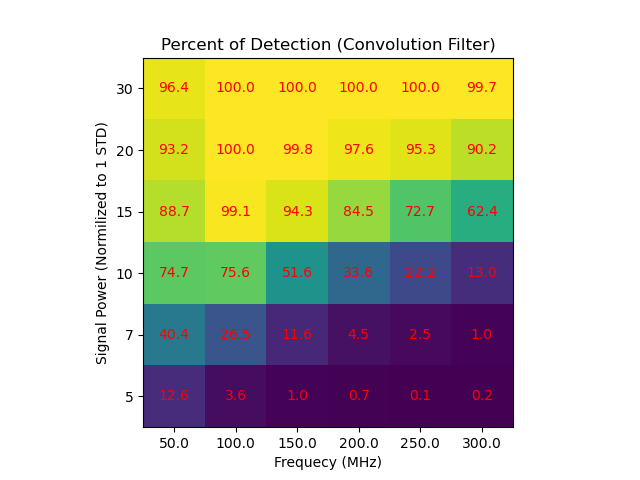

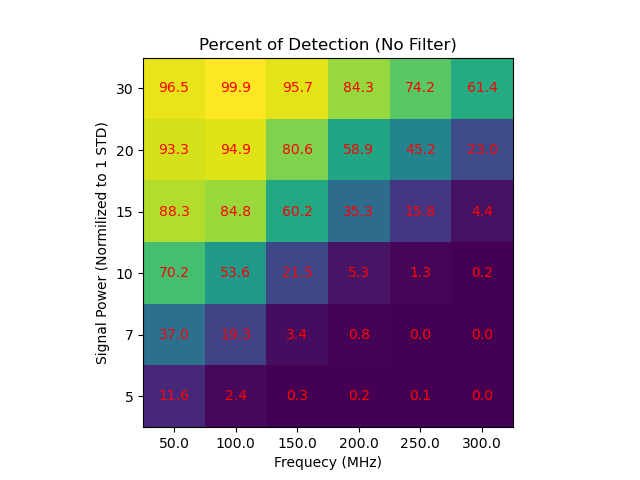

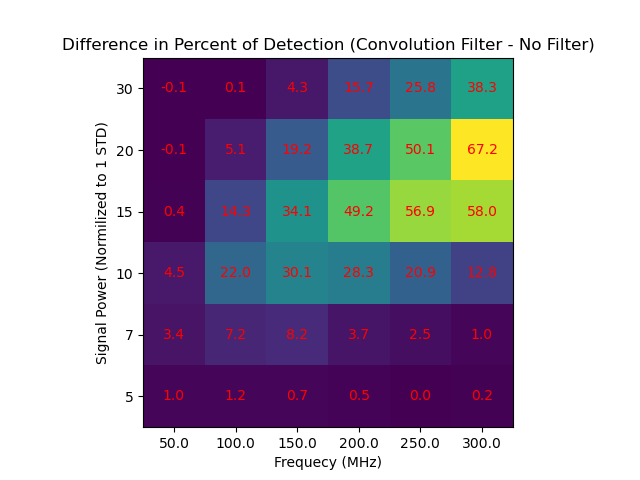

In [126]:
plt.close('all')

plt.figure()
plt.title('Percent of Detection (Convolution Filter)')
plt.yticks(np.arange(len(powersTest)), powersTest)
plt.xticks(np.arange(len(freqsTest)), [freq/1e6 for freq in freqsTest])
plt.imshow(convResultArr)
plt.ylabel('Signal Power (Normilized to 1 STD)')
plt.xlabel('Frequecy (MHz)')
# Overlay temperature values
for i in range(len(powersTest)):
    for j in range(len(freqsTest)):
        plt.annotate(f'{convResultArr[i, j]:.1f}', (j, i), color='red',
                     ha='center', va='center')
plt.show()
plt.colorbar()

plt.figure()
plt.title('Percent of Detection (No Filter)')
plt.yticks(np.arange(len(powersTest)), powersTest)
plt.xticks(np.arange(len(freqsTest)), [freq/1e6 for freq in freqsTest])
plt.imshow(normResultArr)
plt.ylabel('Signal Power (Normilized to 1 STD)')
plt.xlabel('Frequecy (MHz)')
# Overlay temperature values
for i in range(len(powersTest)):
    for j in range(len(freqsTest)):
        plt.annotate(f'{normResultArr[i, j]:.1f}', (j, i), color='red',
                     ha='center', va='center')
plt.show()
plt.colorbar()

plt.figure()
plt.title('Difference in Percent of Detection (Convolution Filter - No Filter)')
plt.yticks(np.arange(len(powersTest)), powersTest)
plt.xticks(np.arange(len(freqsTest)), [freq/1e6 for freq in freqsTest])
plt.imshow(convResultArr - normResultArr)
plt.ylabel('Signal Power (Normilized to 1 STD)')
plt.xlabel('Frequecy (MHz)')
# Overlay temperature values
for i in range(len(powersTest)):
    for j in range(len(freqsTest)):
        plt.annotate(f'{(convResultArr - normResultArr)[i, j]:.1f}', (j, i), color='red',
                     ha='center', va='center')
plt.show()
plt.colorbar()

The following are the old way I was doing this. It has issues but I'm saving it for future refrence

In [115]:
#genDataClass
import numpy as np
import matplotlib.pyplot as plt
#import cupy

class genData:
    '''
    Inputs
    ------------------------
    sigFreqs: array-like
        Frequencies to generate signals. 
        [MHz] 
    sigAmps: array-like
        Amplitudes for signals. 
        Units linear and proportional to voltage, but arbitrary
        Must be same length as sigFreqs 
    mean: float
        mean value for noise
    std: float
        standard deviation of noise
    numSamples: float
        numbers of samples to capture. Twice as long as the fft
    sampleRate: float
        rate samples are captured 
        [MHz]
    numAvg: int
        number of averages to be computed using averaging methods
    
    
    Attributes
    ------------------------
    timeArr: np array
        array of times which signal is sampled by ADC
        [us]
    freqs: np array
        frequencies corosponding to bins of fft
        [MHz]
    
    '''
    def __init__(self,
            sigFreqs, 
            sigAmps,
            sigQs,
            mean,
            std, 
            numSamples,
            sampleRate,
            numAvg):
        
        #check for valid args
        if len(sigFreqs) != len(sigAmps):
            raise ValueError('sigFreqs and sigAmps must be same length')
        
        #assign attributes to args
        self.sigFreqs = sigFreqs
        self.sigAmps = sigAmps
        self.sigQs = sigQs
        self.mean = mean
        self.std = std
        self.numSamples = numSamples
        self.numAvg = numAvg
        
        #compute additional attributes
        self._halfNumSamples = self.numSamples//2
        self.sampleRate = sampleRate
        self.timeArr = cupy.asarray([i for i in range(0, self.numSamples)])/self.sampleRate
        self._signals = cupy.zeros(len(self.timeArr))
        for i in range(len(self.sigFreqs)):
            #self._phaseArr = cupy.random.normal(1, 1/self.sigQs[i], size=self.numSamples)
            self._phaseArr = [i/self.sigQs in range(int(-self.numSamples/2), int(self.numSamples/2))]
            self._signals += self.sigAmps[i]*cupy.sin(2*cupy.pi*(self.sigFreqs[i]*self.timeArr*self._phaseArr))
        self.freqs = np.linspace(0, self.sampleRate//2, self.numSamples//2)[1:]
        self.genTimeDataGpu()
        
        '''
        ###Testing 8bit###
        self._signals = np.zeros(len(self.timeArr), dtype = np. int8)
        for i in range(len(self.sigFreqs)):
            self._signals += np.rint(self.sigAmps[i] * np.sin(2*np.pi * self.sigFreqs[i] * self.timeArr))
        '''
        
    def genTimeData(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = np.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*(self.fft**2)/(self.numSamples**2 * 50)
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeDataGpu(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = cupy.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = (noiseData + self._signals)
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = cupy.abs(cupy.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = cupy.asarray(2*self.fft**2/(self.numSamples**2 * 50))
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeData8Bit(self):
        noiseData = np.asarray(
            np.rint(np.random.normal(mean, std, 2**24)), dtype = np. int8)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)

        
    def computePowAvg(self):
        self.powAvg = cupy.asarray(self.powSpec)
        for i in range(1, self.numAvg):
            #print(i)
            self.genTimeDataGpu()
            self.powAvg = self.powAvg * (i-1)/i + self.powSpec/i

    def setNumAvg(self, numAvg):
        self.numAvg = numAvg


In [116]:
binWidth = 1 #Hz
freqStart= 100e6 #MHz
freqStop = 100.1e6 #MHz

noiseStd = 1

snr = 5
sigQ = 1e6
sigFreq = 100.051e6

interferenceSigSnr = 0
interferenceQ = sigQ / 100
interferenceFreq = 100.07e6

signalAmp = snr * noiseStd
interferenceSigAmp = interferenceSigSnr * noiseStd

fftLenMultplierList = [1,2,4,8,16,32,64,128,128*2, 128*4,128*8, 128*16]
plt.close('all')
for fftLenMultplier in fftLenMultplierList:
    noiseStd = 1/np.sqrt(fftLenMultplier)
    binWidth = 35/fftLenMultplier
    freqs = np.arange(freqStart, freqStop, binWidth)
    numBins = len(freqs)
    ###generate spectrum in the frequency domain. White noise + other stuff##
    #antennaShit = 0 * np.sin(2.45*freqs* np.pi) +1.5
    noiseSpec = np.random.normal(0, noiseStd, numBins)
    signal = gaussian(freqs, sigFreq, sigFreq/sigQ, signalAmp/fftLenMultplier)
    spur = np.zeros(numBins)
    spur[int(numBins*0.35)] = 0
    #wide gaussian simulating interfering signal with wrong Q
    interferenceSig = 0 #gaussian(freqs, interferenceFreq, sigFreq/interferenceQ, interferenceSigAmp)
    spec = noiseSpec + signal + interferenceSig + spur + interferenceSigAmp

    limit = 5 * noiseStd
    
    #testSig = gaussian(freqs[0:len(freqs)//100], len(freqs)//200, sigFreq/sigQ, 1)
    #convolution = np.convolve(spec, gaussian(freqs, sigFreq, sigFreq/sigQ, 1), mode='same')
    convolution = cupy.convolve(cupy.asarray(spec), cupy.asarray(gaussian(freqs, sigFreq, sigFreq/sigQ, 1)), mode='same').get()
    #convolution = np.convolve(spec, testSig)
    #convolution = convolution[int(numBins/2): int(3*numBins/2)]

    noise = convolution[int(numBins/10):int(2*numBins/10)].std()
    limitConvolve = 5*noise

    plt.figure()
    plt.title('Spectrum, fft %i longer than run 1' % fftLenMultplier)
    plt.plot(freqs, spec, label = 'total spectrum')
    plt.plot(freqs, signal + interferenceSig + spur, label = 'injected spur and signal(s)', alpha = .7)
    plt.plot((freqStart, freqStop),(limit,limit), 'r--', label = '5$\sigma$ Limit')
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Filtered Linear Power (arb)')
    #plt.legend()

    plt.figure()
    plt.plot(freqs,convolution)
    plt.plot((freqStart, freqStop),(limitConvolve,limitConvolve), 'r--', label = '5 $\sigma$')
    plt.plot(freqs, signal + interferenceSig + spur)
    plt.title('Spectrum convolved fft %i longer than run 1' % fftLenMultplier)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Convolution units?')


NameError: name 'cupy' is not defined

In [117]:
sigFreqs = [.6790379]
sigAmps = [.005]
sigQs = [5e3]
mean = 0
std = 0
numSamples = 2**14
sampleRate = 2 #MHz
numAvg = 2
myData = genData(sigFreqs,sigAmps,sigQs,mean,std,numSamples,sampleRate,numAvg)

myData.setNumAvg(1)
myData.computePowAvg();
powAvg = myData.powAvg.get()

plt.figure()
plt.title('Simulated Bicon in Room')
plt.scatter(myData.freqs , (powAvg))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Linear')

NameError: name 'cupy' is not defined

In [ ]:
#Show that std \propto length of fft
#(it is)

numAvg = 10000
std = 1
plt.close('all')
measuredStdList = []
numSamplesList = [2**11, 2**12,2**13,2**14, 2**15, 2**16, 2**17, 2**18, 2**19]

for numSamples in numSamplesList:
    myData = genData(sigFreqs,sigAmps,mean,std,numSamples,sampleRate,numAvg)
    myData.computePowAvg();
    powAvg1 = myData.powAvg.get()
    stdMeas = powAvg1.std()
    meanMeas = powAvg1.mean()
    #print(stdMeas)
    #print(meanMeas)
    measuredStdList.append(stdMeas)


plt.figure()
plt.title('Simulated Bicon in Room')
plt.plot(myData.freqs + freqShift, powAvg1)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Linear')

plt.figure()
plt.loglog(numSamplesList, measuredStdList)




In [81]:
numSamples = 10
a = [i/100 for i in range(int(-numSamples/2), int(numSamples/2))]
for i in a:
    print(i)


-0.05
-0.04
-0.03
-0.02
-0.01
0.0
0.01
0.02
0.03
0.04


1638400.0


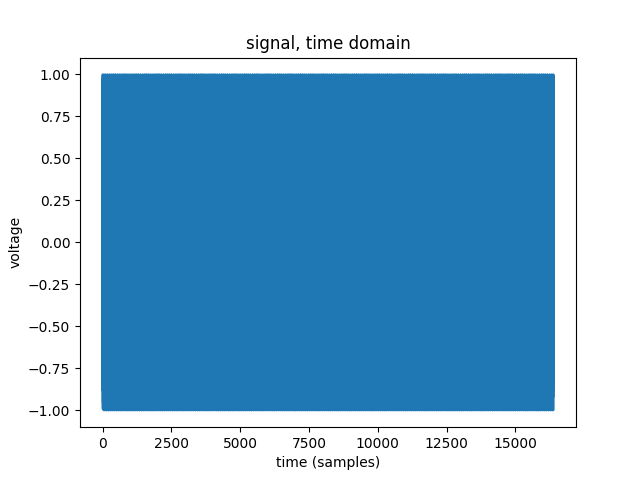

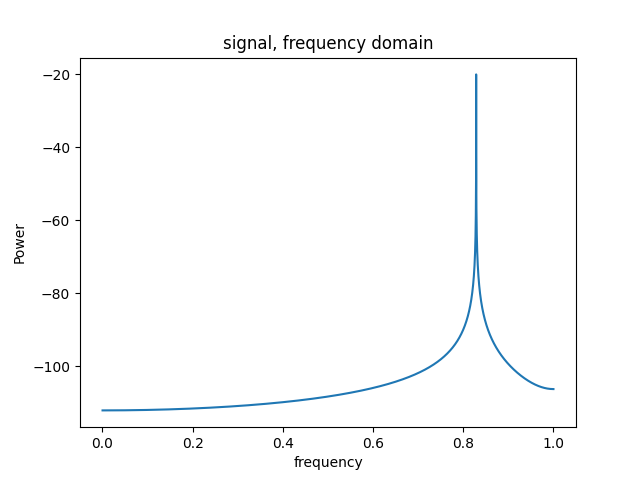

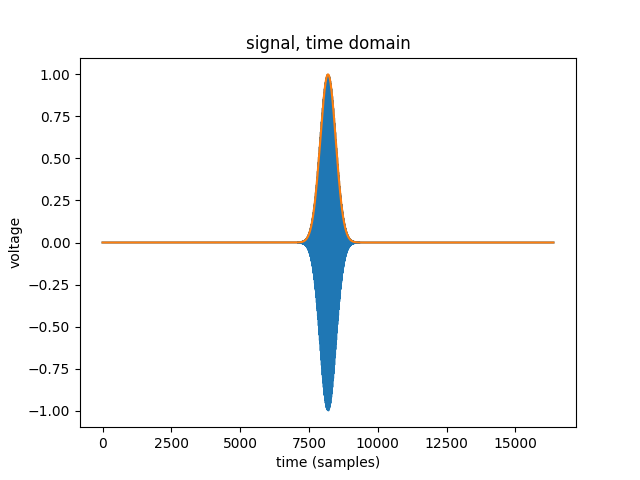

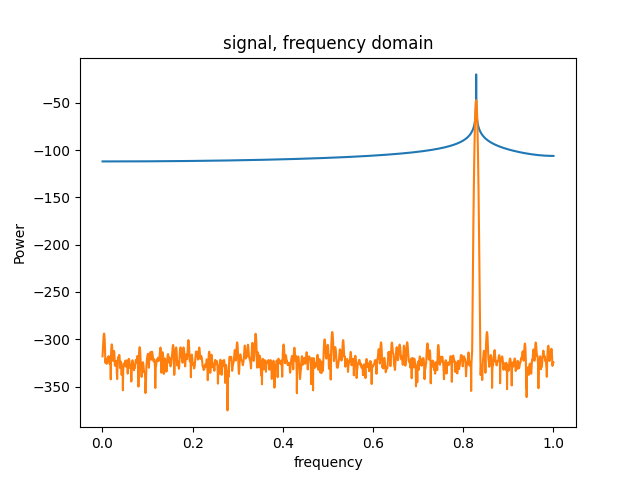

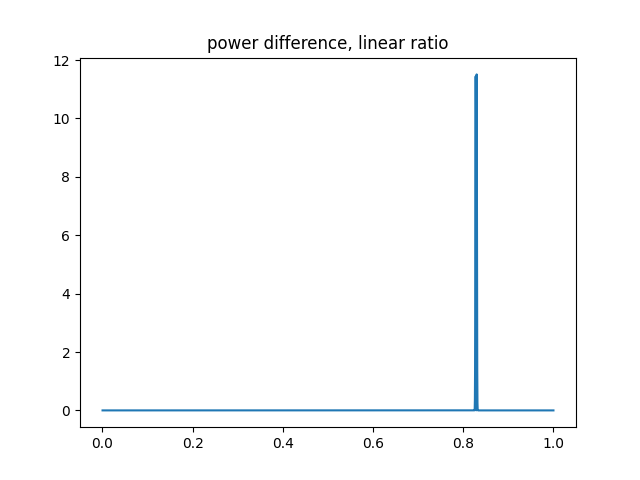

In [36]:
#simulate signal of finite width
amp = 1
sampleRate = 2 #MHz
numSamples = 2**14
sigFreq = .8285 #MHz
noiseStd = .0
freq = 100 #MHz, some frequency we are scanning
measQ = freq/(sampleRate/2) * numSamples
print(measQ)
sigQ = 1e3


timeArr = cupy.asarray([i for i in range(0, numSamples)])/sampleRate
signal = amp*cupy.sin(2*cupy.pi*(sigFreq*timeArr))
signalNp = signal.get()

plt.close('all')
plt.figure()
plt.title('signal, time domain')
plt.plot(signalNp)
plt.ylabel('voltage')
plt.xlabel('time (samples)')

freqs = np.linspace(0, sampleRate//2, numSamples//2)[1:]
fft = cupy.abs(cupy.fft.fft(signal)[1:(numSamples//2)])  
powSpec = cupy.asarray(2*fft**2/(numSamples**2 * 50))
powSpecNp = powSpec.get()

plt.figure()
plt.title('signal, frequency domain')
plt.plot(freqs, 10*np.log10(powSpecNp))
plt.ylabel('Power')
plt.xlabel('frequency')

#Now modify the time domain signal by multiplication by a gaussian
def cuGaussian(nu, nu0, deltaNu, a):
    return a * cupy.exp(-1/2 * (nu - nu0)**2 / deltaNu)
    #comment to ignore normilization
    #return a/(deltaNu * 2 * np.pi) * np.exp(-1/2 * (nu - nu0)**2 / deltaNu)

timeArr = cupy.asarray([i for i in range(0, numSamples)])/sampleRate
gaussWindow = cuGaussian(timeArr, numSamples/4, sampleRate * sigQ *10, 1)
noise = cupy.random.normal(0, noiseStd, size=numSamples)
signal = amp*cupy.sin(2*cupy.pi*(sigFreq*timeArr)) * gaussWindow 
timeData = signal + noise
timeDataNp = timeData.get()


plt.figure()
plt.title('signal, time domain')
plt.plot(timeDataNp)
plt.plot(gaussWindow.get())
plt.ylabel('voltage')
plt.xlabel('time (samples)')

freqs = np.linspace(0, sampleRate//2, numSamples//2)[1:]
fft = cupy.abs(cupy.fft.fft(timeData)[1:(numSamples//2)])  
powSpec = cupy.asarray(2*fft**2/(numSamples**2 * 50))
powSpecRealNp = powSpec.get()


plt.figure()
plt.title('signal, frequency domain')
plt.plot(freqs, 10*np.log10(powSpecNp), label = 'ideal sig')
plt.plot(freqs, 10*np.log10(powSpecRealNp), label = 'real sig')
plt.ylabel('Power')
plt.xlabel('frequency')

plt.figure()
plt.title('power difference, linear ratio')
plt.plot(freqs, (powSpecRealNp / powSpecNp))


In [ ]:
#See effect of splitting signal 